In [3]:
import os
import numpy as np
import torch

from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

from cfg.config import get_default_config
from data_utils.datasets import CUBDataset
from metrics.preparation import LoadEvalModel, prepare_moments
from metrics.fid import frechet_inception_distance
from metrics.ins import eval_features
from models.dfgan_attr import Generator, Discriminator, CondEpilogue, DFGAN
from models.dfgan import Generator as Generator_base, Discriminator as Discriminator_base, \
    CondEpilogue as CondEpilogue_base, DFGAN as DFGAN_base
from models.damsm import RNN_ENCODER
from utils.utils import prepare_folders, MetricLogger
import wandb
import argparse

/home/janice9902/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from PIL import Image
from IPython.display import display

In [5]:
def generate_model(cfg, model_path, mode="attr"):
    # CUDA
    assert torch.cuda.is_available()
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda:{}".format(cfg.TRAINING.device))
    
    # Load Test Data
    data_path = os.path.join(cfg.DATA.data_dir, cfg.DATA.dataset_name)
    dataset_kwargs = {"data_path": data_path, 
                      "num_captions": cfg.DATA.num_captions, 
                      "num_words": cfg.DATA.num_words, 
                      "img_resolution": cfg.DATA.img_size}
    
    test_dataset = CUBDataset(split=cfg.METRICS.ref_dataset, **dataset_kwargs)
    
    loader_kwargs = {"batch_size": cfg.TRAINING.batch_size, 
                     "num_workers": cfg.TRAINING.num_workers, 
                     "pin_memory": True}
    
    test_loader = DataLoader(test_dataset, shuffle=False, **loader_kwargs)
    
    # Load real moments\
    eval_model = LoadEvalModel(eval_backbone=cfg.METRICS.eval_backbone, device=device)
    eval_model.eval()
    
    moment_path = "./runs/moments/{}_{}_prenone_{}_postfriendly_{}_moments.npz".format(
        cfg.DATA.dataset_name, cfg.DATA.img_size, cfg.METRICS.ref_dataset, cfg.METRICS.eval_backbone)
    mu_real, sigma_real = prepare_moments(moment_path=moment_path, 
                                          loader=test_loader if cfg.METRICS.ref_dataset == "test" else train_loader, 
                                          model=eval_model, 
                                          quantize=True, 
                                          device=device)
    
    # DFGAN
    z_dim = cfg.MODEL.z_dim
    c_dim = cfg.MODEL.c_dim
    img_resolution = cfg.DATA.img_size
    img_channels = cfg.DATA.img_channels
    channel_base = cfg.MODEL.channel_base

    if mode=="base":
        # Pre-trained DAMSM
        vocab_size = len(test_dataset.id2word)
        text_encoder = RNN_ENCODER(vocab_size, nhidden=cfg.MODEL.c_dim)
        text_encoder_state_dict = torch.load(os.path.join(data_path, "DAMSMencoder", "text_encoder200.pth"), map_location="cpu")
        text_encoder.load_state_dict(text_encoder_state_dict)
        text_encoder = text_encoder.eval().requires_grad_(False).to(device)

    if mode=="attr":
        generator = Generator(z_dim, c_dim, img_resolution, img_channels, channel_base, num_attributes=312)
    else:
        generator = Generator_base(z_dim, c_dim, img_resolution, img_channels, channel_base)
    generator = generator.train().requires_grad_(False).to(device)
    
    if mode=="attr":
        discriminator = Discriminator(img_resolution, img_channels, channel_base)
    else:
        discriminator = Discriminator_base(img_resolution, img_channels, channel_base)
    discriminator = discriminator.train().requires_grad_(False).to(device)
    
    if mode=="attr":
        cond_epilogue = CondEpilogue(312, channel_base)
    else:
        cond_epilogue = CondEpilogue_base(c_dim, channel_base)
    cond_epilogue = cond_epilogue.train().requires_grad_(False).to(device)
    
    if mode=="attr":
        model = DFGAN(G=generator, D=discriminator, C=cond_epilogue)
    else:
        model = DFGAN_base(G=generator, D=discriminator, C=cond_epilogue)
        
    state_dict = torch.load(model_path, map_location="cpu")
    
    # load to model
    model.G.load_state_dict(state_dict=state_dict["G_state_dict"])
    model.D.load_state_dict(state_dict=state_dict["D_state_dict"])
    model.C.load_state_dict(state_dict=state_dict["C_state_dict"])
    
    model.to(device)

    return model

In [6]:
cfg = get_default_config()
cfg.merge_from_file("./cfg/cub_dfgan.yaml")

In [7]:
device = torch.device("cuda:{}".format(cfg.TRAINING.device))

# Attributes

In [47]:
model = generate_model(cfg, model_path="./runs/checkpoints/CUB_200_2011_dfgan_attr/best_weights.pth", mode="attr")

Moments loaded from path!


In [48]:
from sklearn.preprocessing import MultiLabelBinarizer

In [49]:
binarizer = MultiLabelBinarizer(classes=np.arange(1, 313))

In [51]:
def generate_images(model, labels):
    gen_z = model._sample_inputs(batch_size=labels.shape[0], device=device)
    gen_images = model.G(gen_z, torch.Tensor(labels).to(device))
    gen_images = ((gen_images + 1) / 2).clamp(0.0, 1.0)\
    
    # generate real images
    gen_images = gen_images.mul(255).add_(0.5).clamp_(0, 255).permute(0, 2, 3, 1).to("cpu", torch.uint8).numpy()

    for image in gen_images:
        im= Image.fromarray(image)
        display(im)

In [52]:
import joblib
D = joblib.load("./data/CUB_200_2011/test/attributes.pkl")

In [53]:
keys = list(D.keys())

904
[11, 22, 41, 46, 55, 77, 95, 107, 122, 146, 154, 169, 199, 204, 215, 218, 227, 245, 250, 255, 290, 312] ['has_wing_color::brown', 'has_wing_color::white', 'has_underparts_color::brown', 'has_underparts_color::yellow', 'has_breast_pattern::solid', 'has_tail_shape::fan-shaped_tail', 'has_head_pattern::spotted', 'has_breast_color::brown', 'has_throat_color::brown', 'has_eye_color::black', 'has_forehead_color::brown', 'has_under_tail_color::brown', 'has_belly_color::brown', 'has_belly_color::yellow', 'has_wing_shape::broad-wings', 'has_size::large_(16_-_32_in)', 'has_shape::owl-like', 'has_belly_pattern::solid', 'has_primary_color::brown', 'has_primary_color::yellow', 'has_bill_color::black', 'has_wing_pattern::multi-colored']


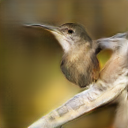

In [54]:
import random

idx = random.choice(keys)
print(idx)
print(D[idx]["attributes"], D[idx]["attributes_txt"])

labels = [D[idx]["attributes"]]
labels = binarizer.fit_transform(labels)

generate_images(model, labels)

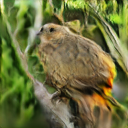

In [60]:
new_labels = [[20, 22, 41, 46, 55, 77,\
    95, 107, 122, 146, 154, 169, 199,\
    204, 215, 218, 227, 245, 250, 255,\
    290, 312]]

new_labels = binarizer.fit_transform(new_labels)

generate_images(model, new_labels)

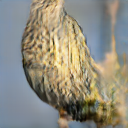

In [126]:
new_labels = [[11, 22, 41, 46, 55, 77,\
    95, 107, 122, 146, 154, 169, 199,\
    204, 215, 218, 227, 246, 250, 255,\
    290, 312]]

new_labels = binarizer.fit_transform(new_labels)

generate_images(model, new_labels)

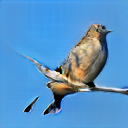

In [154]:
new_labels = [[11, 22, 41, 46, 55, 77,\
    95, 107, 121, 146, 154, 169, 199,\
    204, 215, 218, 227, 245, 250, 255,\
    290, 312]]

new_labels = binarizer.fit_transform(new_labels)

generate_images(model, new_labels)

# Baseline

In [12]:
model = generate_model(cfg, model_path="./runs/checkpoints/CUB_200_2011_dfgan/best_weights.pth", mode="base")

Moments loaded from path!


/home/janice9902/anaconda3/envs/nlp/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [13]:
data_path = os.path.join(cfg.DATA.data_dir, cfg.DATA.dataset_name)
dataset_kwargs = {"data_path": data_path, 
                    "num_captions": cfg.DATA.num_captions, 
                    "num_words": cfg.DATA.num_words, 
                    "img_resolution": cfg.DATA.img_size}
train_dataset = CUBDataset(split="train", **dataset_kwargs)

test_dataset = CUBDataset(split=cfg.METRICS.ref_dataset, **dataset_kwargs)

In [14]:
idx=904

In [48]:
captions = test_dataset[idx]['captions']
for cap in captions:
    print(test_dataset.id2word[cap], end=" ")
print("")
for cap in captions:
    print(cap, end=" ")

bird with light brown crown pale yellow belly light brown wings and white wingbars <end> <end> <end> <end> 
4217 2622 4426 1394 1109 3868 12 964 4426 1394 3824 1946 1902 4206 0 0 0 0 

In [24]:
# define text encoder
from models.damsm import RNN_ENCODER

vocab_size = len(test_dataset.id2word)

text_encoder = RNN_ENCODER(vocab_size, nhidden=cfg.MODEL.c_dim)
text_encoder_state_dict = torch.load(os.path.join(data_path, "DAMSMencoder", "text_encoder200.pth"), map_location="cpu")
text_encoder.load_state_dict(text_encoder_state_dict)
text_encoder = text_encoder.eval().requires_grad_(False).to(device)

/home/janice9902/anaconda3/envs/nlp/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [25]:
def generate_base_images(model, captions, caption_lengths):
    hidden = text_encoder.init_hidden(captions.size(0))
    _, c = text_encoder(captions, caption_lengths, hidden)
    gen_z = model._sample_inputs(batch_size=c.size(0), device=device)
    gen_images = model.G(gen_z, c)
    gen_images = ((gen_images + 1) / 2).clamp(0.0, 1.0)\
    
    # generate real images
    gen_images = gen_images.mul(255).add_(0.5).clamp_(0, 255).permute(0, 2, 3, 1).to("cpu", torch.uint8).numpy()

    for image in gen_images:
        im= Image.fromarray(image)
        display(im)

In [26]:
print(captions)

[4217 2622 4426 1394 1109 3868   12  964 4426 1394 3824 1946 1902 4206
    0    0    0    0]


In [49]:
new_caption1 = captions.copy()
new_caption1[new_caption1==12] = 103
print(new_caption1)
for cap in new_caption1:
    print(test_dataset.id2word[cap], end=" ")

[4217 2622 4426 1394 1109 3868  103  964 4426 1394 3824 1946 1902 4206
    0    0    0    0]
bird with light brown crown pale blue belly light brown wings and white wingbars <end> <end> <end> <end> 

In [50]:
new_caption2 = captions.copy()
new_caption2[new_caption2==3824] = 81
print(new_caption2)
for cap in new_caption2:
    print(test_dataset.id2word[cap], end=" ")

[4217 2622 4426 1394 1109 3868   12  964 4426 1394   81 1946 1902 4206
    0    0    0    0]
bird with light brown crown pale yellow belly light brown bill and white wingbars <end> <end> <end> <end> 

In [51]:
# "bird with light brown crown"
processed_captions = torch.Tensor([
    captions,
    new_caption1,
    new_caption2
]).long().to(device)

/home/janice9902/tmp/ipykernel_20388/738595791.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  processed_captions = torch.Tensor([


In [52]:
caption_lengths = torch.Tensor([
    14, 14, 14
]).to(device)

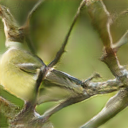

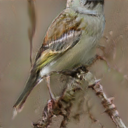

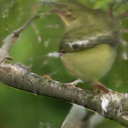

In [53]:
generate_base_images(model, processed_captions, caption_lengths)